### Importando os Pacotes Utilitários

In [1]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tarfile, os
import numpy as np
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Baixando os Conjuntos de Dados do Servidor

In [3]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/CheXpert-v1.0-small.zip', 
                      extract_dir = '/content/CheXpert-v1.0-small', format = 'zip')

In [4]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/vinbigdata.zip', 
                      extract_dir = '/content/vinbigdata/', format = 'zip')

In [5]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/images.zip', 
                      extract_dir = '/content/images/', format = 'zip')

### Organizando e Analisando os Dados

In [6]:
dataset = pd.read_csv('/content/all_datasets.csv', index_col = 0)
dataset_diseases = dataset[((dataset['Opacity'] == 1.0) | 
                            (dataset['Atelectasis'] == 1.0) | 
                            (dataset['Pneumothorax'] == 1.0) | 
                            (dataset['Effusion'] == 1.0)) & 
                            (dataset['Nodule/Mass'] == 0.0) &
                            (dataset['No Finding'] == 0.0)].copy()

dataset_diseases.drop(labels = 'Nodule/Mass', axis = 1, inplace = True)
dataset_diseases.drop(labels = 'No Finding', axis = 1, inplace = True)
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

dataset_no_diseases = dataset[dataset['No Finding'] == 1.0].copy()

dataset_diseases['Abnormal'] = 1.0
dataset_no_diseases['Abnormal'] = 0.0

dataset = pd.concat((dataset_diseases, dataset_no_diseases))

In [7]:
findings = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion', 'No Finding']
findings_pt = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão', 'Normal']

Text(0, 0.5, 'Imagens')

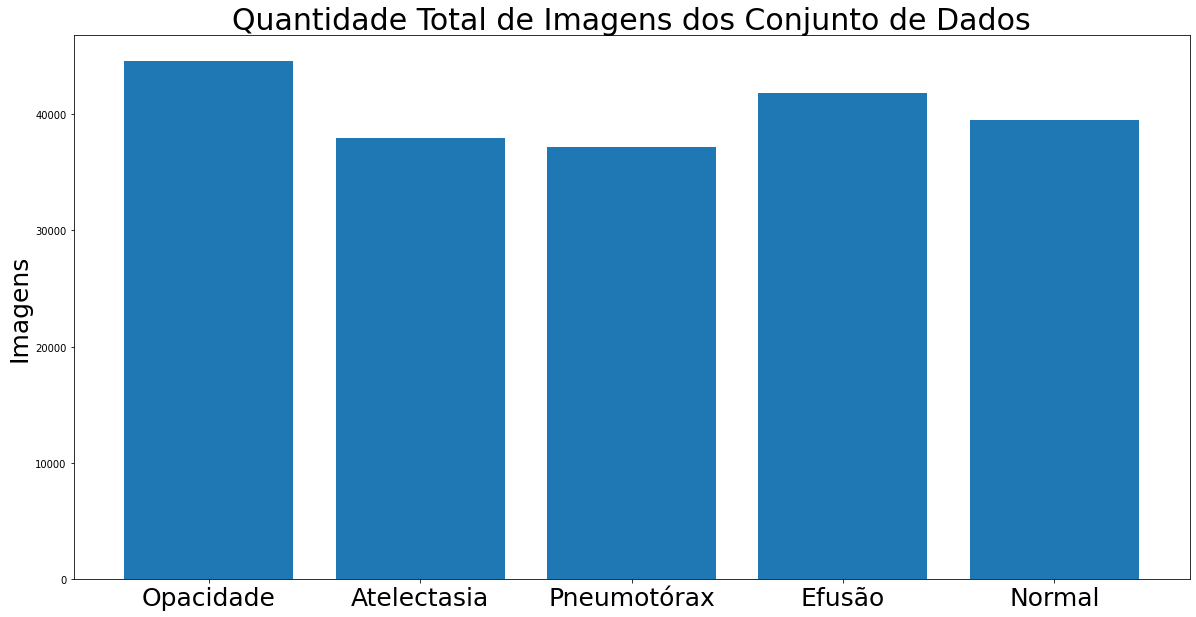

In [8]:
count_findings = list()
for finding in findings:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

In [9]:
opacity = np.array(dataset_diseases['Opacity']).astype(str)
atelectasis = np.array(dataset_diseases['Atelectasis']).astype(str)
pneumothorax = np.array(dataset_diseases['Pneumothorax']).astype(str)
effusion = np.array(dataset_diseases['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset_diseases['labels_ref'] = all_labels

In [10]:
_, dataset_diseases = train_test_split(dataset_diseases, test_size = 0.45011, 
                                       random_state = 42, 
                                       stratify = dataset_diseases['labels_ref'])

dataset = pd.concat((dataset_diseases, dataset_no_diseases))

Text(0, 0.5, 'Imagens')

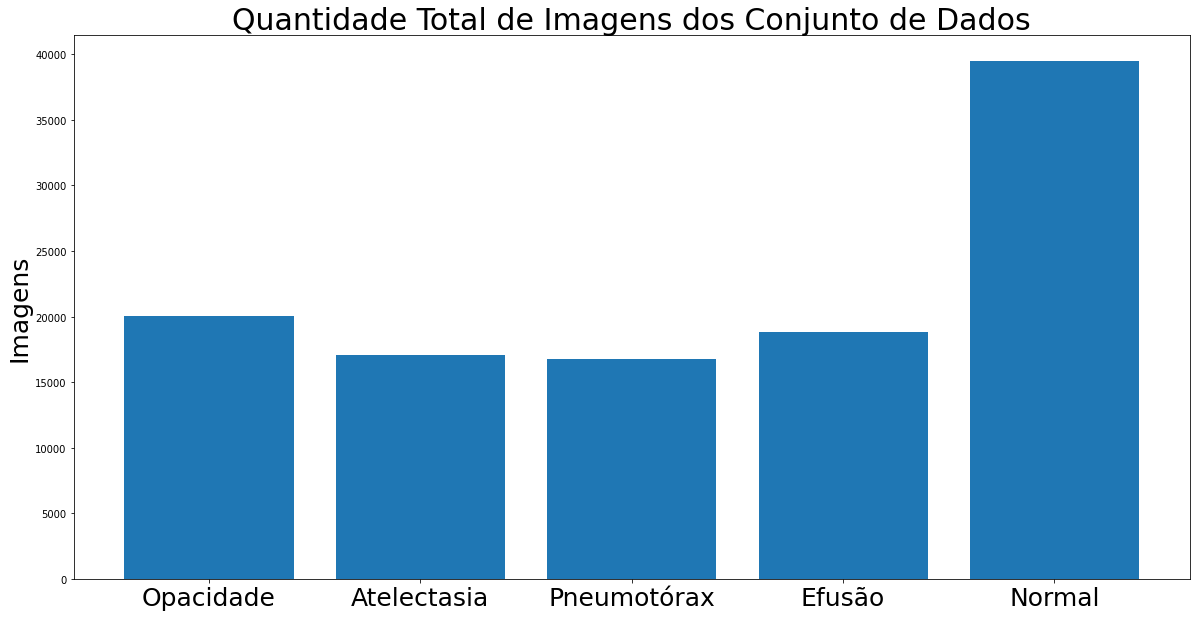

In [11]:
count_findings = list()
for finding in findings:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

Text(0, 0.5, 'Imagens')

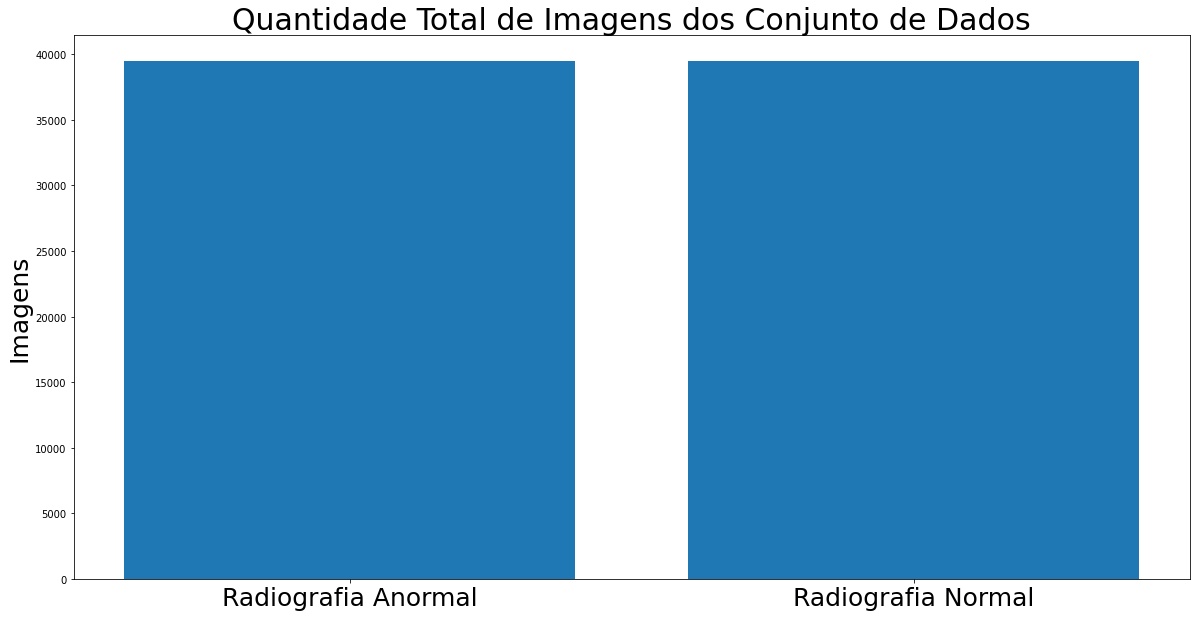

In [12]:
count_findings = list()
count_findings.append(dict(dataset['Abnormal'].value_counts())[1.0])
count_findings.append(dict(dataset['Abnormal'].value_counts())[0.0])

plt.figure(figsize = (20, 10))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

In [13]:
f_train, f_val = train_test_split(dataset, test_size = 0.2, random_state = 42, 
                                  stratify = dataset['Abnormal'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                 stratify = f_val['Abnormal'])

f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

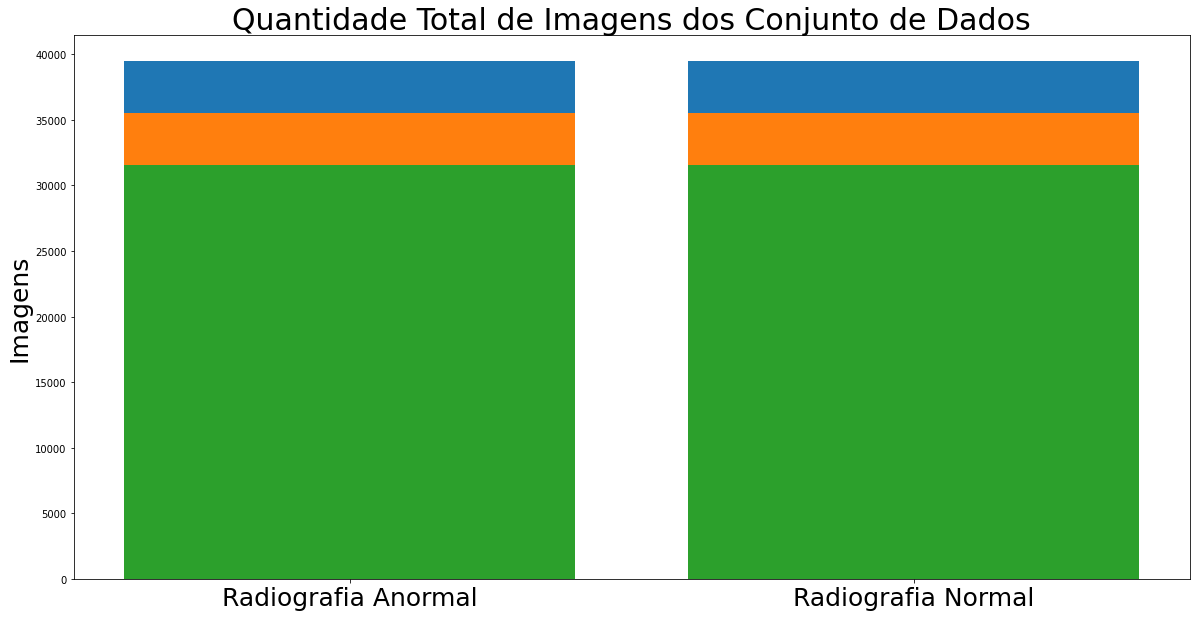

In [14]:
count_train, count_val, count_test = [], [], []
count_train.append(dict(f_train['Abnormal'].value_counts())[1.0])
count_train.append(dict(f_train['Abnormal'].value_counts())[0.0])
count_val.append(dict(f_val['Abnormal'].value_counts())[1.0])
count_val.append(dict(f_val['Abnormal'].value_counts())[0.0])
count_test.append(dict(f_test['Abnormal'].value_counts())[1.0])
count_test.append(dict(f_test['Abnormal'].value_counts())[0.0])

plt.figure(figsize = (20, 10))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], 
        np.sum((count_train, count_val, count_test), axis = 0))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], 
        np.sum((count_train, count_val), axis = 0))
plt.bar(['Radiografia Anormal', 'Radiografia Normal'], count_train)

plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

### Gerador de Imagens do Keras

In [15]:
image_size, batch_size = 256, 64
labels = ['Abnormal']

In [16]:
core_idg = ImageDataGenerator(rescale = 1/255., 
                              shear_range = 0.1, rotation_range = 3, 
                              width_shift_range = 0.05, 
                              height_shift_range = 0.05, fill_mode = 'constant')

train_gen = core_idg.flow_from_dataframe(dataframe = f_train, directory = None, 
                                         x_col = 'Path', y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size), 
                                         shuffle = True)

core_idg = ImageDataGenerator(rescale = 1/255.)

valid_gen = core_idg.flow_from_dataframe(dataframe = f_val, directory = None, 
                                         x_col = 'Path',  y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size),
                                         shuffle = False)

test_gen = core_idg.flow_from_dataframe(dataframe = f_test, directory = None, 
                                        x_col = 'Path', y_col = labels, 
                                        class_mode = 'raw', batch_size = batch_size,
                                        target_size = (image_size, image_size),
                                        shuffle = False)

y_labels_valid = valid_gen.labels
y_labels_test = test_gen.labels

Found 63160 validated image filenames.
Found 7895 validated image filenames.
Found 7895 validated image filenames.


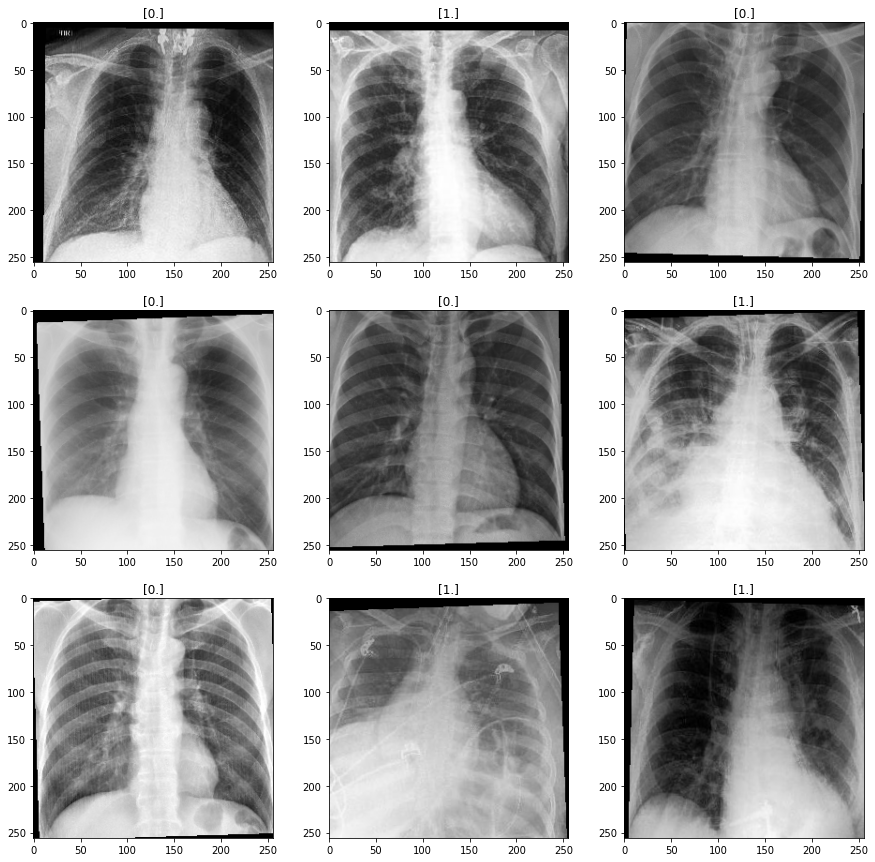

In [17]:
(x,y) = train_gen[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(str(y[count]))
    axs[i,j].imshow(x[count])
    count +=1

### Organinzando uma Função Utilitária de Callback

In [18]:
def get_callbacks(model_name, monitor = 'val_acc',):
    '''
    gerando uma lista de callbacks úteis para o treinamento da rede

    Args:
        model_name (str) --> nome do modelo em análise
        monitor (str) --> métrica de análise a ser monitorada pelo callback

    Returns:
        callbacks (list) --> Lista de callbacks
    '''
    checkpoint_file = f'model.{model_name}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_file,
                                                    verbose = 1, 
                                                    save_best_only = True, 
                                                    monitor = monitor, 
                                                    mode = 'max')
    
    return [checkpoint]

### Definindo uma Função de Congelamento de Camadas

In [19]:
def freeze_layers(conv_base, layer_name):
  '''
  método de treinamento por congelamento de camadas das redes convolucionais

  Args:
    conv_base (tensor) --> camadas convolucionais do modelo
    layer_name (str) --> nome de referência da camada a ser iniciado o 
    congelamento
  '''

  conv_base.trainable = True
  set_trainable = False

  for layer in conv_base.layers:
    if layer.name == layer_name: set_trainable = True
    if set_trainable: layer.trainable = True
    else: layer.trainable = False
  
  return None

### Definindo uma Função de Binarização das Predições

In [20]:
def binarize_preds(pred_array, column, threshold):
  '''
  função que binariza as predições mutirrótulo do modelo

  Args:
    pred_array (array) --> vetor com as predições multirrótulo
    column (int) --> coluna do vetor multirrótulo a ser analisada
    threshold (float) --> valor de threshold a ser considerado na predição
  
  Returns:
    pred_bin (array) --> vetor de predição com os valores binarizados
  '''
  per_100 = pred_array[:,column] * 100
  pred_bin = list()
  for value in per_100:
    if value >= threshold: pred_bin.append(1)
    else: pred_bin.append(0)
  
  return pred_bin

### EfficientNetV2S

In [ ]:
base_model1 = EfficientNetV2S(include_top = False, weights = 'imagenet', 
                              input_shape = (image_size, image_size, 3))
x = base_model1.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
efficientnet = tf.keras.Model(base_model1.input, output)
efficientnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                     loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                     metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'efficientnet', monitor = 'val_auc_4')

In [ ]:
layers_name = list()
for layer in base_model1.layers:
  layers_name.append(layer.name)

block_names = ['input_5', 'block5f_expand_conv', 'block6j_expand_conv']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_5 found!
Bloco block5f_expand_conv found!
Bloco block6j_expand_conv found!


In [ ]:
freeze_layers(conv_base = base_model1, layer_name = block_names[2])
efficientnet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
                 validation_data = valid_gen, epochs = 2, callbacks = callbacks,
                 use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.2236 - auc_4: 0.9672
Epoch 1: val_auc_4 improved from -inf to 0.97539, saving model to model.efficientnet.h5
986/986 [==============================] - 1327s 1s/step - loss: 0.2236 - auc_4: 0.9672 - val_loss: 0.2048 - val_auc_4: 0.9754
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.1928 - auc_4: 0.9751
Epoch 2: val_auc_4 did not improve from 0.97539
986/986 [==============================] - 1157s 1s/step - loss: 0.1928 - auc_4: 0.9751 - val_loss: 0.2692 - val_auc_4: 0.9683


In [ ]:
efficientnet.load_weights('/content/model.efficientnet.h5')
efficientnet.save('model_efficientnet1')
shutil.make_archive(base_name = 'model_efficientnet1', format = 'zip', 
                    root_dir = '/content/model_efficientnet1')
shutil.move('/content/model_efficientnet1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/EfficientNetV2S')

In [ ]:
freeze_layers(conv_base = base_model1, layer_name = block_names[1])
efficientnet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
                 validation_data = valid_gen, epochs = 2, callbacks = callbacks,
                 use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.1963 - auc_4: 0.9743
Epoch 1: val_auc_4 did not improve from 0.97539
986/986 [==============================] - 1189s 1s/step - loss: 0.1963 - auc_4: 0.9743 - val_loss: 1.3762 - val_auc_4: 0.3609
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.1819 - auc_4: 0.9778
Epoch 2: val_auc_4 did not improve from 0.97539
986/986 [==============================] - 1127s 1s/step - loss: 0.1819 - auc_4: 0.9778 - val_loss: 2.2663 - val_auc_4: 0.5967


In [ ]:
efficientnet.load_weights('/content/model.efficientnet.h5')
efficientnet.save('model_efficientnet2')
shutil.make_archive(base_name = 'model_efficientnet2', format = 'zip', 
                    root_dir = '/content/model_efficientnet2')
shutil.move('/content/model_efficientnet2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/EfficientNetV2S')

In [ ]:
freeze_layers(conv_base = base_model1, layer_name = block_names[0])
efficientnet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
                 validation_data = valid_gen, epochs = 2, callbacks = callbacks,
                 use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.1994 - auc_4: 0.9735
Epoch 1: val_auc_4 did not improve from 0.97539
986/986 [==============================] - 1128s 1s/step - loss: 0.1994 - auc_4: 0.9735 - val_loss: 1.8081 - val_auc_4: 0.5522
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.1816 - auc_4: 0.9778
Epoch 2: val_auc_4 did not improve from 0.97539
986/986 [==============================] - 1141s 1s/step - loss: 0.1816 - auc_4: 0.9778 - val_loss: 0.2615 - val_auc_4: 0.9682


In [ ]:
efficientnet.load_weights('/content/model.efficientnet.h5')
efficientnet.save('model_efficientnet3')
shutil.make_archive(base_name = 'model_efficientnet3', format = 'zip', 
                    root_dir = '/content/model_efficientnet3')
shutil.move('/content/model_efficientnet3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/EfficientNetV2S')

In [ ]:
shutil.move('/content/model.efficientnet.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/EfficientNetV2S')

In [ ]:
y_pred_val1 = efficientnet.predict(valid_gen)
y_pred1 = efficientnet.predict(test_gen)
print(f'AUC | Dados de Validação = {efficientnet.evaluate(valid_gen)[1] * 100} %')
print(f'AUC | Dados de Teste = {efficientnet.evaluate(test_gen)[1] * 100} %')

124/124 [==============================] - 161s 1s/step - loss: 0.2048 - auc_4: 0.9754
AUC | Dados de Validação = 97.53941893577576 %
124/124 [==============================] - 158s 1s/step - loss: 0.2075 - auc_4: 0.9752
AUC | Dados de Teste = 97.52097129821777 %


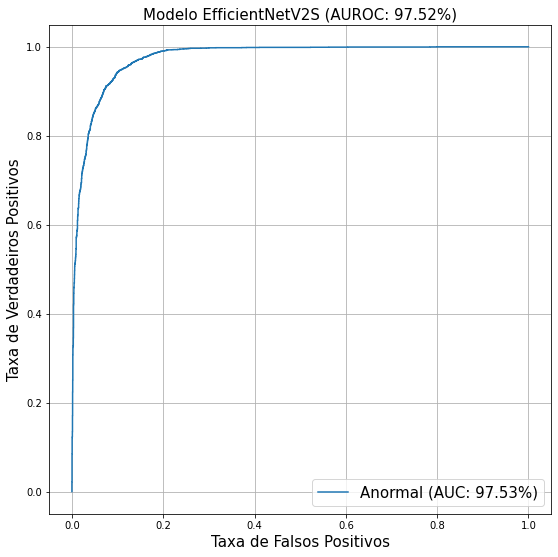

In [ ]:
labels_portugues = ['Anormal']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test[:, idx].astype(int), y_pred1[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test.astype(int), y_pred1)*100)[0:5]
c_ax.set_title('Modelo EfficientNetV2S (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [ ]:
threshold_variation = dict()
for label_index in range(0, len(labels)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin = binarize_preds(pred_array = y_pred_val1, column = label_index, 
                                threshold = threshold)
    matrix = confusion_matrix(y_labels_valid[:, label_index], y_pred_bin)
    precision = matrix[0,0] / (matrix[0,0]+matrix[0,1])
    recall = matrix[0,0] / (matrix[0,0]+matrix[1,0])
    f1_score = (2 * precision*recall) / (precision + recall) 
    threshold_variation[label_index].append(f1_score)

bests_thresholds = list()
for label_index in range(0, len(labels)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [ ]:
for label_index in range(0,1):
  y_pred_bin = binarize_preds(pred_array = y_pred1, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test[:, label_index], y_pred_bin)
  acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
  precision = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall = matrix[0,0]/(matrix[0,0]+matrix[1,0])
  f1_score = (2*precision*recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc*100} % | Precisão = {precision*100} % | '
        f'\nSensibilidade = {recall*100} % | F1 Score = {f1_score*100} %\n')

==Anormal== 
[[3555  393]
 [ 225 3722]], Threshold = 59
Acurácia = 92.17226092463584 % | Precisão = 90.04559270516718 % | 
Sensibilidade = 94.04761904761905 % | F1 Score = 92.00310559006212 %



### DenseNet121

In [ ]:
base_model2 = DenseNet121(include_top = False, weights = 'imagenet', 
                          input_shape = (image_size, image_size, 3))
x = base_model2.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
densenet = tf.keras.Model(base_model2.input, output)
densenet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                 metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'densenet', monitor = 'val_auc')

In [ ]:
layers_name = list()
for layer in base_model2.layers:
  layers_name.append(layer.name)

block_names = ['input_1', 'conv4_block5_0_relu', 'conv5_block4_concat']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_1 found!
Bloco conv4_block5_0_relu found!
Bloco conv5_block4_concat found!


In [ ]:
freeze_layers(conv_base = base_model2, layer_name = block_names[2])
densenet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 2, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.2514 - auc: 0.9592
Epoch 1: val_auc improved from -inf to 0.50063, saving model to model.densenet.h5
986/986 [==============================] - 1006s 988ms/step - loss: 0.2514 - auc: 0.9592 - val_loss: 27.7356 - val_auc: 0.5006
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.2217 - auc: 0.9677
Epoch 2: val_auc improved from 0.50063 to 0.96567, saving model to model.densenet.h5
986/986 [==============================] - 970s 975ms/step - loss: 0.2217 - auc: 0.9677 - val_loss: 0.2897 - val_auc: 0.9657


In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet1')
shutil.make_archive(base_name = 'model_densenet1', format = 'zip', 
                    root_dir = '/content/model_densenet1')
shutil.move('/content/model_densenet1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/DenseNet121')

In [ ]:
freeze_layers(conv_base = base_model2, layer_name = block_names[1])
densenet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 2, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.2089 - auc: 0.9711
Epoch 1: val_auc improved from 0.96567 to 0.96966, saving model to model.densenet.h5
986/986 [==============================] - 965s 969ms/step - loss: 0.2089 - auc: 0.9711 - val_loss: 0.2471 - val_auc: 0.9697
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.2014 - auc: 0.9730
Epoch 2: val_auc did not improve from 0.96966
986/986 [==============================] - 962s 967ms/step - loss: 0.2014 - auc: 0.9730 - val_loss: 0.2350 - val_auc: 0.9682


In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet2')
shutil.make_archive(base_name = 'model_densenet2', format = 'zip', 
                    root_dir = '/content/model_densenet2')
shutil.move('/content/model_densenet2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/DenseNet121')

In [ ]:
freeze_layers(conv_base = base_model2, layer_name = block_names[0])
densenet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 2, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.2009 - auc: 0.9732
Epoch 1: val_auc improved from -inf to 0.97572, saving model to model.densenet.h5
986/986 [==============================] - 981s 974ms/step - loss: 0.2009 - auc: 0.9732 - val_loss: 0.2003 - val_auc: 0.9757
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.1880 - auc: 0.9763
Epoch 2: val_auc did not improve from 0.97572
986/986 [==============================] - 934s 938ms/step - loss: 0.1880 - auc: 0.9763 - val_loss: 0.2300 - val_auc: 0.9724


In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet3')
shutil.make_archive(base_name = 'model_densenet3', format = 'zip', 
                    root_dir = '/content/model_densenet3')
shutil.move('/content/model_densenet3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/DenseNet121')

In [ ]:
shutil.move('/content/model.densenet.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/DenseNet121')

In [ ]:
y_pred_val2 = densenet.predict(valid_gen)
y_pred2 = densenet.predict(test_gen)
print(f'AUC | Dados de Validação = {densenet.evaluate(valid_gen)[1] * 100} %')
print(f'AUC | Dados de Teste = {densenet.evaluate(test_gen)[1] * 100} %')

124/124 [==============================] - 141s 1s/step - loss: 0.2003 - auc: 0.9757
AUC | Dados de Validação = 97.57238626480103 %
124/124 [==============================] - 140s 1s/step - loss: 0.1998 - auc: 0.9748
AUC | Dados de Teste = 97.4767804145813 %


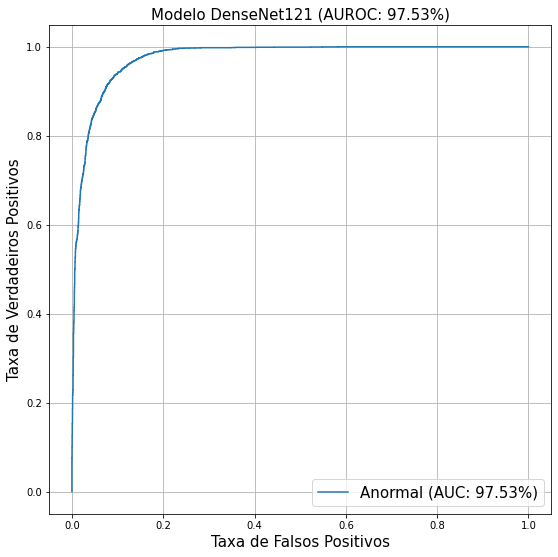

In [ ]:
labels_portugues = ['Anormal']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test[:, idx].astype(int), y_pred2[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test.astype(int), y_pred2)*100)[0:5]
c_ax.set_title('Modelo DenseNet121 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [ ]:
threshold_variation = dict()
for label_index in range(0, len(labels)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin = binarize_preds(pred_array = y_pred_val2, column = label_index, 
                                threshold = threshold)
    matrix = confusion_matrix(y_labels_valid[:, label_index], y_pred_bin)
    precision = matrix[0,0] / (matrix[0,0]+matrix[0,1])
    recall = matrix[0,0] / (matrix[0,0]+matrix[1,0])
    f1_score = (2 * precision*recall) / (precision + recall) 
    threshold_variation[label_index].append(f1_score)

bests_thresholds = list()
for label_index in range(0, len(labels)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [ ]:
for label_index in range(0,1):
  y_pred_bin = binarize_preds(pred_array = y_pred2, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test[:, label_index], y_pred_bin)
  acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
  precision = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall = matrix[0,0]/(matrix[0,0]+matrix[1,0])
  f1_score = (2*precision*recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc*100} % | Precisão = {precision*100} % | '
        f'\nSensibilidade = {recall*100} % | F1 Score = {f1_score*100} %\n')

==Anormal== 
[[3539  409]
 [ 223 3724]], Threshold = 37
Acurácia = 91.9949335022166 % | Precisão = 89.6403242147923 % | 
Sensibilidade = 94.07230196703881 % | F1 Score = 91.80285343709468 %



### InceptionV3

In [ ]:
base_model3 = InceptionV3(include_top = False, weights = 'imagenet', 
                          input_shape = (image_size, image_size, 3))
x = base_model3.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
inception = tf.keras.Model(base_model3.input, output)
inception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                  metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'inception', monitor = 'val_auc')

In [ ]:
layers_name = list()
for layer in base_model3.layers:
  layers_name.append(layer.name)

block_names = ['input_1', 'batch_normalization_30', 'mixed8']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_1 found!
Bloco batch_normalization_30 found!
Bloco mixed8 found!


In [ ]:
freeze_layers(conv_base = base_model3, layer_name = block_names[2])
inception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
              validation_data = valid_gen, epochs = 2, callbacks = callbacks,
              use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.2395 - auc: 0.9627
Epoch 1: val_auc improved from -inf to 0.96217, saving model to model.inception.h5
986/986 [==============================] - 1007s 999ms/step - loss: 0.2395 - auc: 0.9627 - val_loss: 0.3584 - val_auc: 0.9622
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.2045 - auc: 0.9723
Epoch 2: val_auc improved from 0.96217 to 0.97073, saving model to model.inception.h5
986/986 [==============================] - 939s 944ms/step - loss: 0.2045 - auc: 0.9723 - val_loss: 0.2249 - val_auc: 0.9707


In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception1')
shutil.make_archive(base_name = 'model_inception1', format = 'zip', 
                    root_dir = '/content/model_inception1')
shutil.move('/content/model_inception1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/InceptionV3')

In [ ]:
freeze_layers(conv_base = base_model3, layer_name = block_names[1])
inception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
              validation_data = valid_gen, epochs = 2, callbacks = callbacks,
              use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.1952 - auc: 0.9745
Epoch 1: val_auc improved from 0.97073 to 0.97442, saving model to model.inception.h5
986/986 [==============================] - 954s 959ms/step - loss: 0.1952 - auc: 0.9745 - val_loss: 0.2115 - val_auc: 0.9744
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.1854 - auc: 0.9770
Epoch 2: val_auc did not improve from 0.97442
986/986 [==============================] - 963s 968ms/step - loss: 0.1854 - auc: 0.9770 - val_loss: 0.2341 - val_auc: 0.9708


In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception2')
shutil.make_archive(base_name = 'model_inception2', format = 'zip', 
                    root_dir = '/content/model_inception2')
shutil.move('/content/model_inception2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/InceptionV3')

In [ ]:
freeze_layers(conv_base = base_model3, layer_name = block_names[0])
inception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
              validation_data = valid_gen, epochs = 2, callbacks = callbacks,
              use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.1908 - auc: 0.9756
Epoch 1: val_auc did not improve from 0.97442
986/986 [==============================] - 940s 944ms/step - loss: 0.1908 - auc: 0.9756 - val_loss: 0.2123 - val_auc: 0.9726
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.1802 - auc: 0.9783
Epoch 2: val_auc improved from 0.97442 to 0.97597, saving model to model.inception.h5
986/986 [==============================] - 940s 945ms/step - loss: 0.1802 - auc: 0.9783 - val_loss: 0.2134 - val_auc: 0.9760


In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception3')
shutil.make_archive(base_name = 'model_inception3', format = 'zip', 
                    root_dir = '/content/model_inception3')
shutil.move('/content/model_inception3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/InceptionV3')

In [ ]:
shutil.move('/content/model.inception.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/InceptionV3')

In [ ]:
y_pred_val3 = inception.predict(valid_gen)
y_pred3 = inception.predict(test_gen)
print(f'AUC | Dados de Validação = {inception.evaluate(valid_gen)[1] * 100} %')
print(f'AUC | Dados de Teste = {inception.evaluate(test_gen)[1] * 100} %')

124/124 [==============================] - 139s 1s/step - loss: 0.2134 - auc: 0.9760
AUC | Dados de Validação = 97.59728908538818 %
124/124 [==============================] - 137s 1s/step - loss: 0.2257 - auc: 0.9741
AUC | Dados de Teste = 97.40872383117676 %


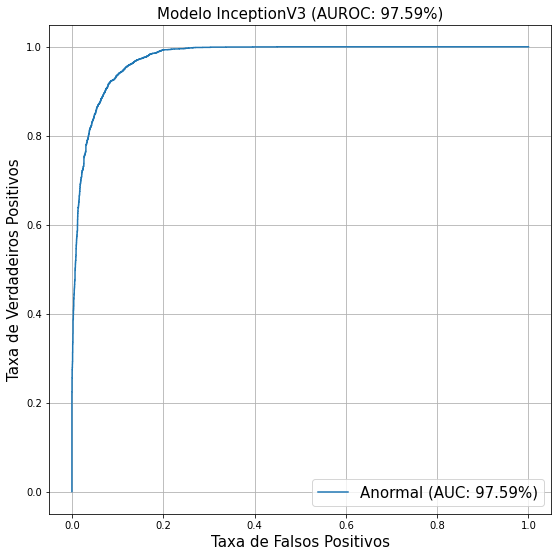

In [ ]:
labels_portugues = ['Anormal']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test[:, idx].astype(int), y_pred3[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test.astype(int), y_pred3)*100)[0:5]
c_ax.set_title('Modelo InceptionV3 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [ ]:
threshold_variation = dict()
for label_index in range(0, len(labels)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin = binarize_preds(pred_array = y_pred_val3, column = label_index, 
                                threshold = threshold)
    matrix = confusion_matrix(y_labels_valid[:, label_index], y_pred_bin)
    precision = matrix[0,0] / (matrix[0,0]+matrix[0,1])
    recall = matrix[0,0] / (matrix[0,0]+matrix[1,0])
    f1_score = (2 * precision*recall) / (precision + recall) 
    threshold_variation[label_index].append(f1_score)

bests_thresholds = list()
for label_index in range(0, len(labels)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [ ]:
for label_index in range(0,1):
  y_pred_bin = binarize_preds(pred_array = y_pred3, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test[:, label_index], y_pred_bin)
  acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
  precision = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall = matrix[0,0]/(matrix[0,0]+matrix[1,0])
  f1_score = (2*precision*recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc*100} % | Precisão = {precision*100} % | '
        f'\nSensibilidade = {recall*100} % | F1 Score = {f1_score*100} %\n')

==Anormal== 
[[3548  400]
 [ 247 3700]], Threshold = 67
Acurácia = 91.80493983533881 % | Precisão = 89.86828774062816 % | 
Sensibilidade = 93.49143610013175 % | F1 Score = 91.64406560764562 %



### Xception

In [ ]:
base_model4 = Xception(include_top = False, weights = 'imagenet', 
                              input_shape = (image_size, image_size, 3))
x = base_model4.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
xception = tf.keras.Model(base_model4.input, output)
xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                 metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'xception', monitor = 'val_auc')

In [22]:
layers_name = list()
for layer in base_model4.layers:
  layers_name.append(layer.name)

block_names = ['input_1', 'block6_sepconv3_act', 'block11_sepconv3_bn']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_1 found!
Bloco block6_sepconv3_act found!
Bloco block11_sepconv3_bn found!


In [23]:
freeze_layers(conv_base = base_model4, layer_name = block_names[2])
xception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 2, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.2186 - auc: 0.9687
Epoch 1: val_auc improved from -inf to 0.96913, saving model to model.xception.h5
986/986 [==============================] - 1100s 1s/step - loss: 0.2186 - auc: 0.9687 - val_loss: 0.2674 - val_auc: 0.9691
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.1880 - auc: 0.9762
Epoch 2: val_auc did not improve from 0.96913
986/986 [==============================] - 1061s 1s/step - loss: 0.1880 - auc: 0.9762 - val_loss: 0.2255 - val_auc: 0.9665


In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception1')
shutil.make_archive(base_name = 'model_xception1', format = 'zip', 
                    root_dir = '/content/model_xception1')
shutil.move('/content/model_xception1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/Xception')

In [25]:
freeze_layers(conv_base = base_model4, layer_name = block_names[1])
xception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 2, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.1923 - auc: 0.9751
Epoch 1: val_auc improved from 0.96913 to 0.97386, saving model to model.xception.h5
986/986 [==============================] - 1058s 1s/step - loss: 0.1923 - auc: 0.9751 - val_loss: 0.2088 - val_auc: 0.9739
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.1772 - auc: 0.9786
Epoch 2: val_auc did not improve from 0.97386
986/986 [==============================] - 1055s 1s/step - loss: 0.1772 - auc: 0.9786 - val_loss: 0.2396 - val_auc: 0.9726


In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception2')
shutil.make_archive(base_name = 'model_xception2', format = 'zip', 
                    root_dir = '/content/model_xception2')
shutil.move('/content/model_xception2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/Xception')

In [27]:
freeze_layers(conv_base = base_model4, layer_name = block_names[0])
xception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 2, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/2
987/986 [==============================] - ETA: 0s - loss: 0.1800 - auc: 0.9780
Epoch 1: val_auc did not improve from 0.97386
986/986 [==============================] - 1053s 1s/step - loss: 0.1800 - auc: 0.9780 - val_loss: 0.2344 - val_auc: 0.9669
Epoch 2/2
987/986 [==============================] - ETA: 0s - loss: 0.1677 - auc: 0.9810
Epoch 2: val_auc did not improve from 0.97386
986/986 [==============================] - 1051s 1s/step - loss: 0.1677 - auc: 0.9810 - val_loss: 0.2794 - val_auc: 0.9681


In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception3')
shutil.make_archive(base_name = 'model_xception3', format = 'zip', 
                    root_dir = '/content/model_xception3')
shutil.move('/content/model_xception3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/Xception')

In [ ]:
shutil.move('/content/model.xception.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_detection/Xception')

In [30]:
y_pred_val4 = xception.predict(valid_gen)
y_pred4 = xception.predict(test_gen)
print(f'AUC | Dados de Validação = {xception.evaluate(valid_gen)[1] * 100} %')
print(f'AUC | Dados de Teste = {xception.evaluate(test_gen)[1] * 100} %')

124/124 [==============================] - 142s 1s/step - loss: 0.2088 - auc: 0.9739
AUC | Dados de Validação = 97.38598465919495 %
124/124 [==============================] - 141s 1s/step - loss: 0.2082 - auc: 0.9725
AUC | Dados de Teste = 97.24671840667725 %


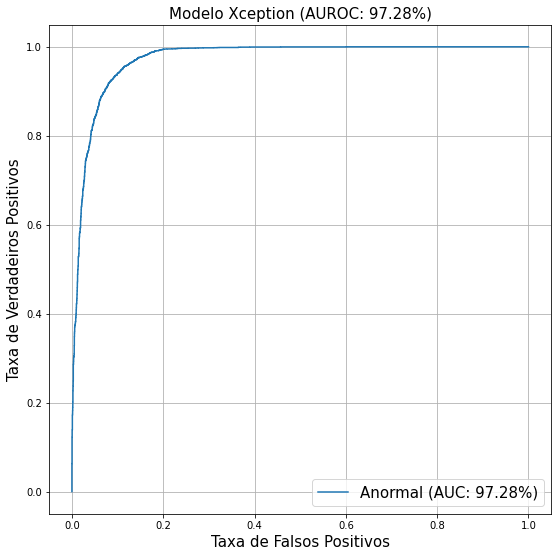

In [31]:
labels_portugues = ['Anormal']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test[:, idx].astype(int), y_pred4[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test.astype(int), y_pred4)*100)[0:5]
c_ax.set_title('Modelo Xception (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [32]:
threshold_variation = dict()
for label_index in range(0, len(labels)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin = binarize_preds(pred_array = y_pred_val4, column = label_index, 
                                threshold = threshold)
    matrix = confusion_matrix(y_labels_valid[:, label_index], y_pred_bin)
    precision = matrix[0,0] / (matrix[0,0]+matrix[0,1])
    recall = matrix[0,0] / (matrix[0,0]+matrix[1,0])
    f1_score = (2 * precision*recall) / (precision + recall) 
    threshold_variation[label_index].append(f1_score)

bests_thresholds = list()
for label_index in range(0, len(labels)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [33]:
for label_index in range(0,1):
  y_pred_bin = binarize_preds(pred_array = y_pred4, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test[:, label_index], y_pred_bin)
  acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
  precision = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall = matrix[0,0]/(matrix[0,0]+matrix[1,0])
  f1_score = (2*precision*recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc*100} % | Precisão = {precision*100} % | '
        f'\nSensibilidade = {recall*100} % | F1 Score = {f1_score*100} %\n')

==Anormal== 
[[3449  499]
 [ 148 3799]], Threshold = 41
Acurácia = 91.80493983533881 % | Precisão = 87.36068895643363 % | 
Sensibilidade = 95.88546010564359 % | F1 Score = 91.42478462557986 %

